<a href="https://colab.research.google.com/github/agayev169/pytorch_examples/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU

In [1]:
!nvidia-smi

Fri Dec 27 07:38:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## Model

### Class

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.__conv1    = nn.Conv2d(1, 16, 3, 1)
        self.__dropout1 = nn.Dropout2d(0.25)
        self.__conv2    = nn.Conv2d(16, 32, 2, 1)
        self.__dropout2 = nn.Dropout2d(0.25)
        self.__fc1      = nn.Linear(6 * 6 * 32, 128)
        self.__dropout3 = nn.Dropout(0.25)
        self.__fc2      = nn.Linear(128, 10)
        self.__dropout4 = nn.Dropout(0.25)

    
    def forward(self, x):
        x = self.__conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.__dropout1(x)
        x = self.__conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.__dropout2(x)
        x = torch.flatten(x, 1)
        x = self.__fc1(x)
        x = self.__dropout3(x)
        x = F.relu(x)
        x = self.__fc2(x)
        x = self.__dropout4(x)
        x = F.softmax(x, dim=1)
        return x

### Test

In [0]:
def test(model, device, test_loader, epoch):
    model.eval()
    
    loss = 0
    acc  = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += F.cross_entropy(out, y, reduction="sum").item()
            pred  = out.argmax(dim=1, keepdim=True)
            acc  += pred.eq(y.view_as(pred)).sum().item()

    loss = loss / len(test_loader.dataset)
    acc  = acc  / len(test_loader.dataset)

    print(f"TEST  --- epoch: {epoch:3d} --- loss: {loss:.6f} --- acc: {acc:.6f}")

### Train

In [0]:
def train(model, device, train_loader, test_loader, optimizer, epochs_n):
    for epoch in range(epochs_n):
        model.train()
        
        epoch_loss = 0
        epoch_acc  = 0

        for batch_i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            epoch_loss += F.cross_entropy(out, y, reduction="sum").item()
            pred        = out.argmax(dim=1, keepdim=True)
            epoch_acc  += pred.eq(y.view_as(pred)).sum().item()

        epoch_loss = epoch_loss / len(train_loader.dataset)
        epoch_acc  = epoch_acc  / len(train_loader.dataset)

        print(f"TRAIN --- epoch: {(epoch + 1):3d} --- loss: {epoch_loss:.6f} --- acc: {epoch_acc:.6f}")

        test(model, device, test_loader, epoch + 1)

## Constants

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
epochs_n   = 10
lr         = 0.001

## Data

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=True, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1037,), (0.3081,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=False, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1037,), (0.3081,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

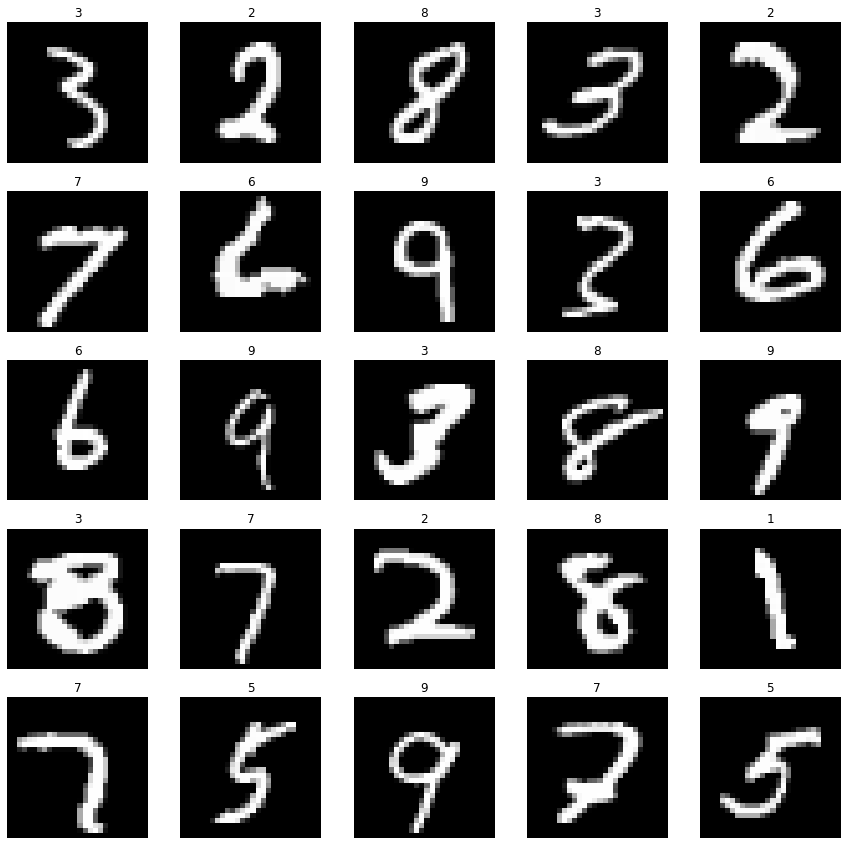

In [8]:
idxs = np.random.randint(0, len(train_loader.dataset), 25)
data_samples = torch.utils.data.Subset(train_loader.dataset, idxs)

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

for i in range(len(idxs)):
    x, y = data_samples[i]
    x = x.numpy().reshape(28, 28)
    ax[i // 5, i % 5].imshow(x, cmap="gray")
    ax[i // 5, i % 5].set_title(y)
    ax[i // 5, i % 5].axis("off")

## Training 

In [9]:
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)

train(model, device, train_loader, test_loader, opt, epochs_n)

TRAIN --- epoch:   1 --- loss: 1.716567 --- acc: 0.738433
TEST  --- epoch:   1 --- loss: 1.501484 --- acc: 0.959900
TRAIN --- epoch:   2 --- loss: 1.653289 --- acc: 0.799517
TEST  --- epoch:   2 --- loss: 1.489406 --- acc: 0.971700
TRAIN --- epoch:   3 --- loss: 1.646138 --- acc: 0.804350
TEST  --- epoch:   3 --- loss: 1.482550 --- acc: 0.978800
TRAIN --- epoch:   4 --- loss: 1.642683 --- acc: 0.808450
TEST  --- epoch:   4 --- loss: 1.483828 --- acc: 0.977500
TRAIN --- epoch:   5 --- loss: 1.638000 --- acc: 0.812500
TEST  --- epoch:   5 --- loss: 1.480650 --- acc: 0.980400
TRAIN --- epoch:   6 --- loss: 1.639919 --- acc: 0.811000
TEST  --- epoch:   6 --- loss: 1.479079 --- acc: 0.982100
TRAIN --- epoch:   7 --- loss: 1.637683 --- acc: 0.813050
TEST  --- epoch:   7 --- loss: 1.479908 --- acc: 0.980900
TRAIN --- epoch:   8 --- loss: 1.636920 --- acc: 0.814500
TEST  --- epoch:   8 --- loss: 1.481007 --- acc: 0.979900
TRAIN --- epoch:   9 --- loss: 1.633518 --- acc: 0.817133
TEST  --- epoc